# Tunning Reg CInc - For CInc

## Importing Libraries

In [2]:
import pandas as pd
rs = 42
import numpy as np
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import loguniform as sp_loguniform
from sklearn.model_selection import KFold,StratifiedKFold
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV ,Lasso, Ridge, ElasticNet, LogisticRegression, LogisticRegression
from sklearn.dummy import DummyClassifier, DummyRegressor
from lightgbm import LGBMRegressor
rs = 42
from  rfpimp import plot_corr_heatmap, feature_corr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  accuracy_score,make_scorer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlxtend
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn import metrics
from numpy import arange
#pip install scikit-plot
from sklearn.metrics import confusion_matrix
#import scikitplot as skplt

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import cross_val_score
from numpy import mean, std
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
# created functions
from evaluation import cross_validation_report_reg, nulls, boxplot_metrics, time_bar_chart, test_validation_bin,test_validation_reg

In [13]:
#!pip install rfpimp


In [3]:
# importing dataset
dataset_l_tr = pd.read_csv('df4r_tr_l.csv')
dataset_l_ho = pd.read_csv('df4r_ho_l.csv')
dataset_l_tr.drop(['Donates','Volunteers'], axis = 1, inplace = True)
dataset_l_ho.drop(['Donates','Volunteers'], axis = 1, inplace = True)

In [4]:
# split the data into X and Y
y_ltr_r = dataset_l_tr['CInc'].copy()
X_ltr = dataset_l_tr.drop(['CInc','quant'],axis=1).copy()

y_lho_r = dataset_l_ho['CInc'].copy()
X_lho = dataset_l_ho.drop(['CInc','quant'],axis=1).copy()


In [5]:
cv = StratifiedKFold(n_splits=10, random_state=rs, shuffle = True)

In [6]:
dataset_l_tr.Planning_Imp.value_counts()

3.0    4785
2.0    3357
1.0    1678
Name: Planning_Imp, dtype: int64

## Models

### Random Forest Tunning

In [7]:
est = RandomForestRegressor(n_jobs = -1, random_state = rs,criterion = 'mse')
rfe = RFE(est, n_features_to_select=  20)
rfe.fit(X_ltr, y_ltr_r)
selected_feat_rf = []
for i in range(X_ltr.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X_ltr.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] == True: 
        selected_feat_rf.append(X_ltr.columns[i]) 

Column: Bachelor_GPA, Selected True, Rank: 1.000
Column: Bachelor_Honors, Selected False, Rank: 35.000
Column: Age, Selected True, Rank: 1.000
Column: Gender, Selected True, Rank: 1.000
Column: Scholarship_Percent, Selected True, Rank: 1.000
Column: First_Comp_Size, Selected True, Rank: 1.000
Column: Curr_Comp_Size, Selected True, Rank: 1.000
Column: Country_First_Job, Selected False, Rank: 24.000
Column: Years_Worked_Foreign, Selected True, Rank: 1.000
Column: Senior_Position, Selected True, Rank: 1.000
Column: People_in_Charge, Selected True, Rank: 1.000
Column: Negotiation_Imp, Selected True, Rank: 1.000
Column: TeamWork_Imp, Selected True, Rank: 1.000
Column: Innovation_Imp, Selected True, Rank: 1.000
Column: Communication_Imp, Selected False, Rank: 4.000
Column: Planning_Imp, Selected True, Rank: 1.000
Column: No_Created_Ventures, Selected True, Rank: 1.000
Column: Used_Incubator_program, Selected False, Rank: 52.000
Column: Board_Member, Selected False, Rank: 2.000
Column: NonPro

In [8]:
selected_feat_rf

['Bachelor_GPA',
 'Age',
 'Gender',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'Senior_Position',
 'People_in_Charge',
 'Negotiation_Imp',
 'TeamWork_Imp',
 'Innovation_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Campus_MTY',
 'Curr_Loc_Foreign',
 'CurrE_Owner_Freelancer',
 'CurrE_Senior Manager',
 'FInc',
 'work_hours_week']

In [19]:
selected_feat_rf = ['Bachelor_GPA',
 'Age',
 'Gender',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'Senior_Position',
 'People_in_Charge',
 'Negotiation_Imp',
 'TeamWork_Imp',
 'Innovation_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Campus_MTY',
 'Curr_Loc_Foreign',
 'CurrE_Owner_Freelancer',
 'CurrE_Senior Manager',
 'FInc',
 'work_hours_week']

In [36]:
def get_models():
    models = dict()
    for i in range(2, 21):
        rfe = RFE(estimator=est, n_features_to_select=i)
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',est)])
    return models
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, random_state=rs, shuffle = True)
    scores = -cross_val_score(model,X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

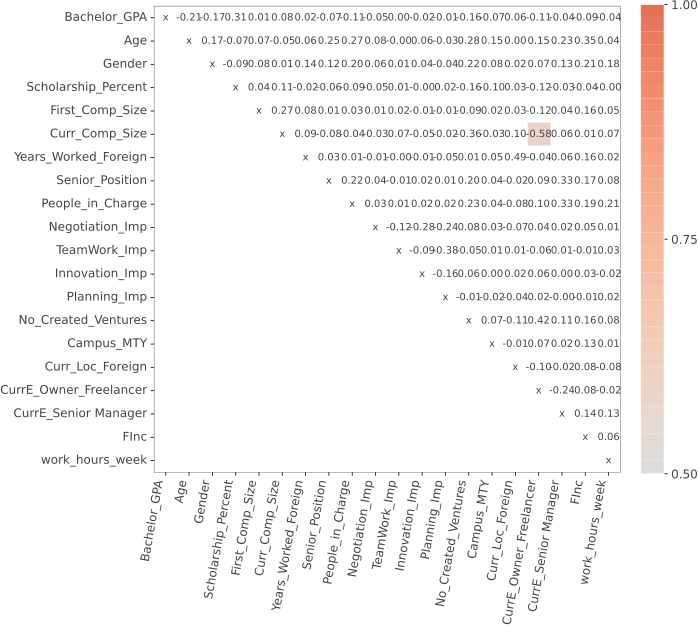

In [11]:
# Correlation Heatmap

viz = plot_corr_heatmap(X_ltr[selected_feat_rf],figsize=(10,10), color_threshold=0.5,
                      cmap=None,
                      value_fontsize=10,
                      label_fontsize=12,
                      precision=2,
                      xrot=80)

viz.save('multi_col.png')
viz

In [12]:
rf_grid_search= GridSearchCV(estimator = est, param_grid={'n_estimators': [10, 100, 500,1000], 'min_samples_leaf': [2,4,6,8],'min_samples_split' : [2, 5, 10] }, n_jobs = -1, cv = cv, scoring = 'neg_mean_absolute_error', error_score=0, verbose = 2)
rf_grid_win = rf_grid_search.fit(X_ltr[selected_feat_rf], y_ltr_r)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [13]:
# Get the estimator
best_clf_rf = rf_grid_win.best_estimator_
best_clf_rf
#results in data frame
rf_results = pd.DataFrame(rf_grid_win.cv_results_)
# show the first 5 rows
display(rf_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.630720,0.739458,0.061751,0.062138,2,2,10,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-34959.136700,-34168.447369,...,-32770.750047,-31974.316666,-32034.263458,-33828.378632,-33956.954851,-33647.647762,-34377.215307,-33430.684638,973.256516,48
1,6.865762,3.619223,3.074433,3.557086,2,2,100,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-33878.843963,-33465.879204,...,-31745.595277,-30984.550802,-30835.532919,-32321.790059,-32227.402216,-33103.284797,-33510.648345,-32352.645085,1041.199436,36
2,13.327389,5.929657,8.082065,4.098855,2,2,500,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-33730.610927,-33291.722729,...,-31802.052788,-30712.818984,-30928.824206,-32235.580216,-32144.021902,-32934.297088,-33437.812986,-32254.865664,1015.951029,33
3,22.950026,3.915324,9.627537,3.527302,2,2,1000,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-33769.343661,-33219.812288,...,-31755.162106,-30664.992570,-31039.312295,-32276.748686,-32120.758951,-32896.856508,-33408.650418,-32246.062422,1006.751342,32
4,8.569166,5.451067,2.700627,2.089821,2,5,10,"{'min_samples_leaf': 2, 'min_samples_split': 5...",-34889.654922,-33943.968412,...,-32858.655096,-32121.883553,-31901.981396,-33646.896854,-33909.353488,-33665.592065,-34302.924005,-33362.722060,943.692131,47


In [14]:
# Report the before-and-afterscores
est = RandomForestRegressor(random_state=rs)
print ("\nUnoptimized model:\n------")
# evaluate model
n_scores = cross_val_score(est,X_ltr[selected_feat_rf], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Unoptimized model:
------
Accuracy score: -32817.190 (1061.787)


In [15]:
rf_scores = np.array(rf_results.mean_test_score)
print ("Best gridsearch parameters\n------")
print (rf_grid_win.best_params_)
print ("----------")
print ("Best score\n------")
print (-rf_grid_win.best_score_)

Best gridsearch parameters
------
{'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 500}
----------
Best score
------
31882.198057846057


In [16]:
rf_reg = RandomForestRegressor(random_state = rs, criterion = 'mse', min_samples_leaf = 8, n_estimators=500, min_samples_split = 2)

In [17]:
rf_reg.get_params(deep = True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Lasso Logistic Regression

In [18]:
model_pipe = Pipeline([('scaler', StandardScaler()),
    ('model', TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])
params={'model__regressor__alpha':  np.linspace(0.001, 0.06, 100)}

reg_grid_search = GridSearchCV(model_pipe, param_grid= params,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

reg_grid_win = reg_grid_search.fit(X_ltr,y_ltr_r)
print('MAE: %.3f' % -reg_grid_win.best_score_)
print('Config: %s' % reg_grid_win.best_params_)

MAE: 30624.904
Config: {'model__regressor__alpha': 0.001}


In [53]:
#model_pipe = Pipeline([('scaler', StandardScaler()),
#    ('model', TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp))
#])
#params={'model__regressor__alpha':  np.linspace(0.001, 0.06, 100)}

#reg_grid_search = GridSearchCV(model_pipe, param_grid= params,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#reg_grid_win = reg_grid_search.fit(X_ltr,y_ltr_r)
#print('MAE: %.3f' % -reg_grid_win.best_score_)
#print('Config: %s' % reg_grid_win.best_params_)

In [51]:
#model_pipe = Pipeline([('scaler', StandardScaler()),
 #   ('model', TransformedTargetRegressor(ElasticNet(), func=np.log, inverse_func=np.exp))
#)
#params={'model__regressor__alpha':  np.linspace(0.001, 0.06, 100),
#'model__regressor__l1_ratio': arange(0, 1, 0.01)}


#reg_grid_win = GridSearchCV(model_pipe, param_grid= params,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#reg_grid_win.fit(X_ltr,y_ltr_r)
#print('MAE: %.3f' % -reg_grid_win.best_score_)
#print('Config: %s' % reg_grid_win.best_params_)

In [19]:
# Get the estimator
best_clf_lr = reg_grid_win.best_estimator_
best_clf_lr
#results in data frame
lr_results = pd.DataFrame(reg_grid_win.cv_results_)
# show the first 5 rows
display(lr_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.313558,0.065962,0.010309,0.001848,0.001,{'model__regressor__alpha': 0.001},-30659.275552,-31080.257417,-30162.378301,-30189.196383,-28650.360933,-30754.319400,-30420.978651,-31016.311475,-31137.562232,-32178.404491,-30624.904483,860.164842,1
1,0.302249,0.065632,0.009808,0.001601,0.001596,{'model__regressor__alpha': 0.001595959595959596},-30670.851031,-31071.923176,-30185.665415,-30203.488095,-28668.450637,-30739.226915,-30412.610959,-31009.958478,-31135.826118,-32185.298805,-30628.329963,854.536713,2
2,0.294943,0.088504,0.010109,0.001702,0.002192,{'model__regressor__alpha': 0.002191919191919192},-30685.535726,-31052.738447,-30208.956937,-30223.827343,-28695.775810,-30723.738111,-30410.554819,-31001.758755,-31126.248486,-32188.030806,-30631.716524,844.636572,3
3,0.248505,0.052974,0.010109,0.002258,0.002788,{'model__regressor__alpha': 0.002787878787878788},-30699.667411,-31038.770285,-30220.794801,-30245.992587,-28729.767636,-30714.301116,-30410.878560,-30994.960237,-31114.690035,-32191.300923,-30636.112359,834.162369,4
4,0.218380,0.048913,0.009207,0.001991,0.003384,{'model__regressor__alpha': 0.003383838383838384},-30719.290666,-31035.851693,-30238.389578,-30264.559701,-28761.644394,-30698.881606,-30411.778268,-30992.089016,-31108.918227,-32193.190002,-30642.459315,824.935972,5


In [20]:
lr = Lasso(random_state=rs, alpha  = 0.001)

In [21]:
sbs = SFS(lr, 
          k_features=20, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5,
          n_jobs=-1)

In [22]:
sbs = sbs.fit(X_ltr, y_ltr_r)
print('\nSequential Backward Selection (k=20):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)


Sequential Backward Selection (k=20):
(1, 2, 3, 4, 6, 8, 9, 10, 16, 18, 28, 30, 33, 36, 38, 62, 63, 64, 68, 69)
CV Score:
0.49811733884082426


In [24]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [23]:
selected_feat_lr = X_ltr.columns[[sbs.k_feature_idx_]]
selected_feat_lr

Index(['Bachelor_Honors', 'Age', 'Gender', 'Scholarship_Percent',
       'Curr_Comp_Size', 'Years_Worked_Foreign', 'Senior_Position',
       'People_in_Charge', 'No_Created_Ventures', 'Board_Member',
       'Nationality_For', 'School_Other', 'Campus_MTY', 'Campus_Virtual',
       'Curr_Loc_Foreign', 'CurrE_Manager', 'CurrE_Owner_Freelancer',
       'CurrE_Senior Manager', 'CInd_Tertiary', 'FInc'],
      dtype='object')

In [25]:
selected_feat_lr = ['Bachelor_Honors', 'Age', 'Gender', 'Scholarship_Percent',
       'Curr_Comp_Size', 'Years_Worked_Foreign', 'Senior_Position',
       'People_in_Charge', 'No_Created_Ventures', 'Board_Member',
       'Nationality_For', 'School_Other', 'Campus_MTY', 'Campus_Virtual',
       'Curr_Loc_Foreign', 'CurrE_Manager', 'CurrE_Owner_Freelancer',
       'CurrE_Senior Manager', 'CInd_Tertiary', 'FInc']

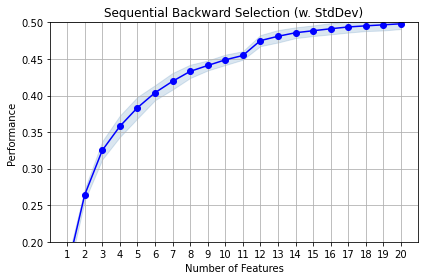

In [26]:
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.ylim([0.2, 0.5])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.savefig('sffs_linreg.png')
plt.show()

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

threshold = 20  # the number of most relevant features
#sel_ = SelectFromModel(lr,max_features = threshold)
#sel_ = SelectKBest(score_func=chi2, k = threshold)
#sel_.fit(X_ltr, y_ltr_r)
#selected_feat_lr = X_ltr.columns[(sel_.get_support())]
#from sklearn.feature_selection import mutual_info_classif
#high_score_features = []
#feature_scores = mutual_info_classif(X_ltr, y_ltr_r, random_state=rs)
#for score, f_name in sorted(zip(feature_scores, X_ltr.columns), reverse=True)[:threshold]:
        #print(f_name, score)
        #high_score_features.append(f_name)
#sel_ = RFE(lr, n_features_to_select= 20)
#sel_.fit(X_ltr, y_ltr_r)
#selected_feat_lr = X_ltr.columns[(sel_.get_support())]

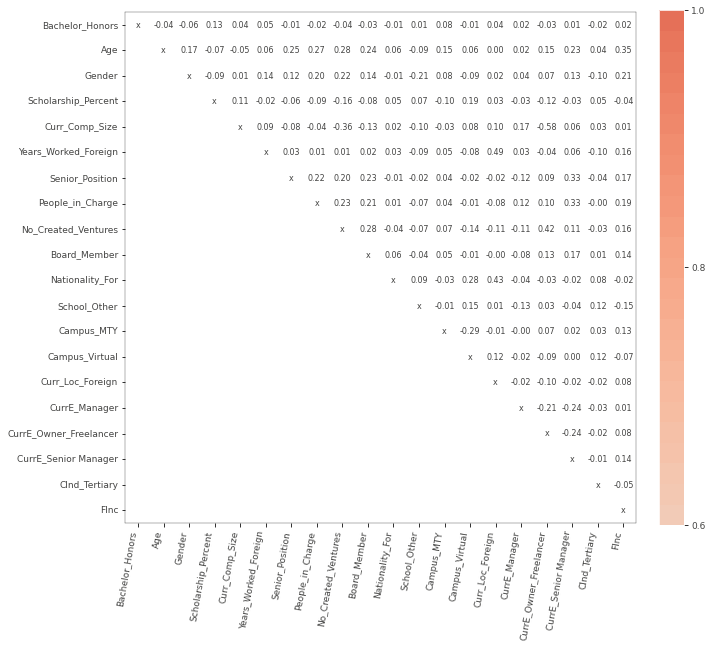

In [28]:
viz = plot_corr_heatmap(X_ltr[selected_feat_lr],figsize=(10,10))

In [8]:
#selected_feat_lr  = ['Gender', 'Years_Worked_Foreign', 'Senior_Position', 'Donates','Nationality_For', 'School_Other', 'Curr_Loc_Foreign','FirstE_Analyst or Assistant', 'FInd_Other', 'FInd_Primary','FInd_Quaternary', 'FInd_Secondary', 'FInd_Tertiary', 'ccsize_large','ccsize_self', 'ccsize_small', 'CurrE_Employee','CurrE_Owner_Freelancer', 'CurrE_Senior Manager', 'CInd_Tertiary']

In [29]:
# Report the before-and-afterscores
est = Ridge(random_state=rs)
print ("\nUnoptimized model:\n------")

# evaluate model
n_scores = cross_val_score(est,X_ltr[selected_feat_lr], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Unoptimized model:
------
Accuracy score: -34445.345 (962.661)


In [30]:
print ("Best gridsearch parameters\n------")
print (reg_grid_win.best_params_)
# evaluate model
n_scores = cross_val_score(lr,X_ltr[selected_feat_lr], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print ("Best score\n------")
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Best gridsearch parameters
------
{'model__regressor__alpha': 0.001}
Best score
------
Accuracy score: -34447.120 (962.456)


In [31]:
lr_reg =Lasso(random_state=rs, alpha  = 0.001)

### Light Gradient Boosting Tunning

In [32]:
est = LGBMRegressor(random_state = rs)
rfe = RFE(est, n_features_to_select=  20)
rfe.fit(X_ltr, y_ltr_r)
selected_feat_lgb = []
for i in range(X_ltr.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X_ltr.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] == True: 
        selected_feat_lgb.append(X_ltr.columns[i])   

Column: Bachelor_GPA, Selected True, Rank: 1.000
Column: Bachelor_Honors, Selected False, Rank: 22.000
Column: Age, Selected True, Rank: 1.000
Column: Gender, Selected True, Rank: 1.000
Column: Scholarship_Percent, Selected True, Rank: 1.000
Column: First_Comp_Size, Selected True, Rank: 1.000
Column: Curr_Comp_Size, Selected True, Rank: 1.000
Column: Country_First_Job, Selected False, Rank: 33.000
Column: Years_Worked_Foreign, Selected True, Rank: 1.000
Column: Senior_Position, Selected True, Rank: 1.000
Column: People_in_Charge, Selected True, Rank: 1.000
Column: Negotiation_Imp, Selected False, Rank: 13.000
Column: TeamWork_Imp, Selected False, Rank: 2.000
Column: Innovation_Imp, Selected True, Rank: 1.000
Column: Communication_Imp, Selected False, Rank: 21.000
Column: Planning_Imp, Selected True, Rank: 1.000
Column: No_Created_Ventures, Selected True, Rank: 1.000
Column: Used_Incubator_program, Selected False, Rank: 48.000
Column: Board_Member, Selected True, Rank: 1.000
Column: Non

In [33]:
selected_feat_lgb

['Bachelor_GPA',
 'Age',
 'Gender',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'Senior_Position',
 'People_in_Charge',
 'Innovation_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Board_Member',
 'Campus_MTY',
 'Curr_Loc_Foreign',
 'CurrE_Owner_Freelancer',
 'CurrE_Senior Manager',
 'CInd_Tertiary',
 'FInc',
 'work_hours_week']

In [34]:
selected_feat_lgb = ['Bachelor_GPA',
 'Age',
 'Gender',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'Senior_Position',
 'People_in_Charge',
 'Innovation_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Board_Member',
 'Campus_MTY',
 'Curr_Loc_Foreign',
 'CurrE_Owner_Freelancer',
 'CurrE_Senior Manager',
 'CInd_Tertiary',
 'FInc',
 'work_hours_week']

>20 31575.855 (959.877)


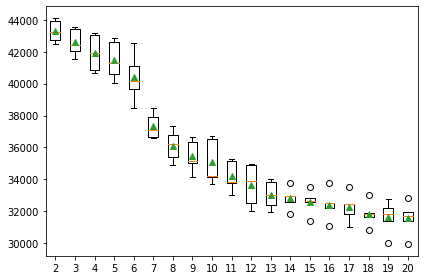

In [37]:
# evaluate the models and store results
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_ltr, y_ltr_r)
    results.append(scores)
    names.append(name)
print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

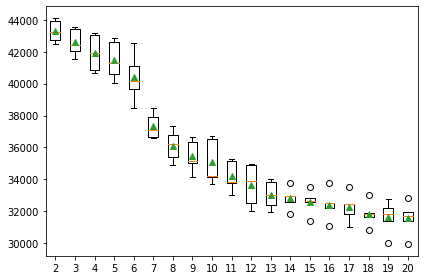

In [38]:
plt.boxplot(results, labels=names, showmeans=True)
plt.savefig('rfe_lgb.png')
plt.show()

In [39]:
selected_feat_lgb = ['Bachelor_GPA',
 'Age',
 'Gender',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'Senior_Position',
 'People_in_Charge',
 'Innovation_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Board_Member',
 'Campus_MTY',
 'Curr_Loc_Foreign',
 'CurrE_Owner_Freelancer',
 'CurrE_Senior Manager',
 'CInd_Tertiary',
 'FInc',
 'work_hours_week']

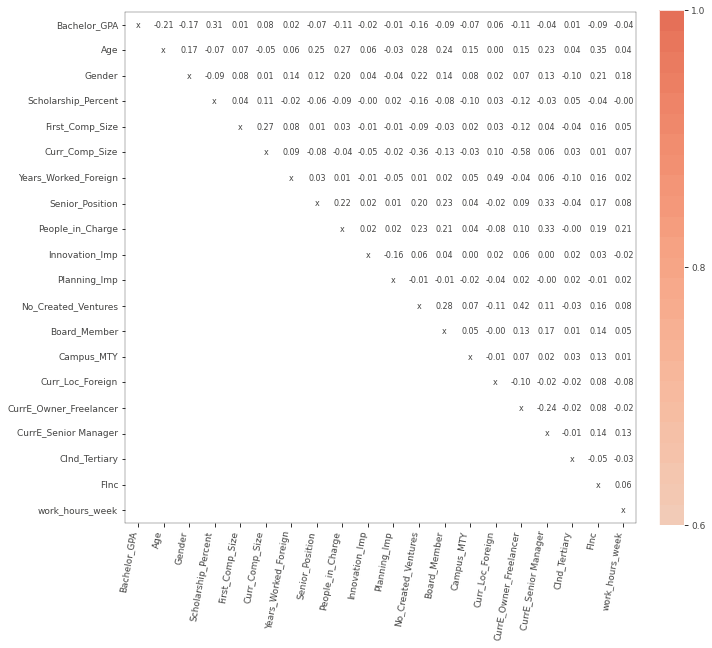

In [40]:
viz = plot_corr_heatmap(X_ltr[selected_feat_lgb],figsize=(10,10))

In [41]:
pipe_lgb = Pipeline(steps=[('s',rfe),('m',est)])
# evaluate model
n_scores = cross_val_score(pipe_lgb, X_ltr, y_ltr_r, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: -31270.611 (810.439)


In [42]:
lgb_grid_search= GridSearchCV(estimator = est, param_grid={'max_depth': [2,4,6,8], 'n_estimators': [10, 100, 500], 'num_leaves': [4,16,32,64] , 'learning_rate':list(np.logspace(np.log(0.005), np.log(0.2),base = np.exp(1), num= 10)) }, n_jobs = -1, cv = cv, scoring = 'neg_mean_absolute_error', error_score=0, verbose = 2)
lgb_grid_win = lgb_grid_search.fit(X_ltr[selected_feat_lgb], y_ltr_r)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


In [43]:
# Get the estimator
best_clf_lgb = lgb_grid_win.best_estimator_
best_clf_lgb
#results in data frame
lgb_results = pd.DataFrame(lgb_grid_win.cv_results_)
# show the first 5 rows
display(lgb_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098982,0.012806,0.007708,0.001098,0.005,2,10,4,"{'learning_rate': 0.005000000000000004, 'max_d...",-52261.321588,...,-50645.525757,-50663.445483,-50640.628815,-50114.858166,-50582.439054,-50264.287088,-51961.096587,-50902.061915,681.202038,477
1,0.080663,0.007427,0.007012,0.001672,0.005,2,10,16,"{'learning_rate': 0.005000000000000004, 'max_d...",-52261.321588,...,-50645.525757,-50663.445483,-50640.628815,-50114.858166,-50582.439054,-50264.287088,-51961.096587,-50902.061915,681.202038,477
2,0.082658,0.006859,0.007404,0.001430,0.005,2,10,32,"{'learning_rate': 0.005000000000000004, 'max_d...",-52261.321588,...,-50645.525757,-50663.445483,-50640.628815,-50114.858166,-50582.439054,-50264.287088,-51961.096587,-50902.061915,681.202038,477
3,0.087665,0.005447,0.007611,0.001280,0.005,2,10,64,"{'learning_rate': 0.005000000000000004, 'max_d...",-52261.321588,...,-50645.525757,-50663.445483,-50640.628815,-50114.858166,-50582.439054,-50264.287088,-51961.096587,-50902.061915,681.202038,477
4,0.187549,0.012208,0.012413,0.001430,0.005,2,100,4,"{'learning_rate': 0.005000000000000004, 'max_d...",-47946.395070,...,-46535.020955,-46265.382596,-45859.242487,-45877.715559,-46040.910335,-46048.377702,-47381.164469,-46480.601139,671.290265,394


In [44]:
lgb_scores = np.array(lgb_results.mean_test_score)
print ("Best gridsearch parameters\n------")
print (lgb_grid_win.best_params_)
print ("----------")
print ("Best score\n------")
print (lgb_grid_win.best_score_)

Best gridsearch parameters
------
{'learning_rate': 0.01709975946676697, 'max_depth': 8, 'n_estimators': 500, 'num_leaves': 32}
----------
Best score
------
-30570.73293184396


In [45]:
# Report the before-and-afterscores
est = LGBMRegressor(random_state=rs)
print ("\nUnoptimized model:\n------")
# evaluate model
n_scores = cross_val_score(est,X_ltr[selected_feat_lgb], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Unoptimized model:
------
Accuracy score: -30743.703 (1062.610)


In [46]:
lgbm_reg = LGBMRegressor(random_state = rs,  max_depth = 8, n_estimators =  500, num_leaves = 32, learning_rate = 0.01709975946676697)

In [48]:
print ("Best score\n------")
n_scores = cross_val_score(lgbm_reg,X_ltr[selected_feat_lgb], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Best score
------
Accuracy score: -30570.733 (927.807)


In [49]:
print ("Best score\n------")
n_scores = cross_val_score(lgbm_reg,X_ltr[selected_feat_lgb], y_ltr_r,scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Best score
------
Accuracy score: 0.549 (0.027)


In [46]:
# Save the object in a python file
#import pickle
#with open('tuned_models/binary_lgb_model_win.data','wb') as data:
    #pickle.dump(lgb_grid_win, data)
#with open('tuned_models/binary_lgb_model_grid.data','wb') as data:
    #pickle.dump(lgb_grid_search, data)

## Evaluation

In [50]:
regressors = {}
mae_results = {}
r2_results = {}
r2_adj = {}
rmse = {}
reg_time = {}
regressors['r2'] = r2_results
regressors['r2_adj'] = r2_adj
regressors['rmse'] = rmse
regressors['mae'] = mae_results
regressors['time'] = reg_time
regressors

{'r2': {}, 'r2_adj': {}, 'rmse': {}, 'mae': {}, 'time': {}}

In [51]:
dummy = DummyRegressor( strategy = 'mean')

In [52]:
name = 'Lasso w/Selected Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr[selected_feat_lr],y_ltr_r,lr_reg, model_name = name, scale = True, log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 0.3613016605377197 sec.
Model: Lasso w/Selected Features
 R2 : 0.4555765804727475
Adjusted R2: 0.44424622834939165
 MAE : 31071.66066755897
RMSE: 50431.450825596796


In [53]:
name = 'Lasso w/All Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,lr_reg, model_name = name, scale = True, log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 1.991642951965332 sec.
Model: Lasso w/All Features
 R2 : 0.4675512116490491
Adjusted R2: 0.4260085039865024
 MAE : 30637.00597515709
RMSE: 49879.91908441862


In [54]:
name = 'RF w/Selected Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr[selected_feat_rf],y_ltr_r,rf_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 273.51153802871704 sec.
Model: RF w/Selected Features
 R2 : 0.5206402893543706
Adjusted R2: 0.510664020662474
 MAE : 31907.24973124601
RMSE: 47325.66684475234


In [55]:
name = 'RF w/All Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,rf_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 592.2617695331573 sec.
Model: RF w/All Features
 R2 : 0.5427532203067732
Adjusted R2: 0.5070779221109281
 MAE : 30765.14355801105
RMSE: 46220.416101273295


In [56]:
name = 'LGBM w/Selected Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr[selected_feat_lgb],y_ltr_r,lgbm_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 11.014050006866455 sec.
Model: LGBM w/Selected Features
 R2 : 0.5490714931896322
Adjusted R2: 0.5396869248897287
 MAE : 30564.303524114697
RMSE: 45892.687415440436


In [57]:
name = 'LGBM w/All Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,lgbm_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 11.919825792312622 sec.
Model: LGBM w/All Features
 R2 : 0.5690979551465891
Adjusted R2: 0.5354781252734109
 MAE : 29472.493155712706
RMSE: 44864.42426274411


In [58]:
name = 'Dummy Regressor'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,dummy, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 0.07306075096130371 sec.
Model: Dummy Regressor
 R2 : -0.001202984649721417
Adjusted R2: -0.07931882191360078
 MAE : 51555.354309340015
RMSE: 68439.81013417282


## Hold Out Validation

In [59]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


In [60]:
predictions = test_validation_reg(lr_reg, X_ltr, y_ltr_r, X_lho,selected_feat_lr)
model_name = 'Lasso validation w/Selected Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 33704.930841330206
R2 score: 0.5208938337718318
R2 adjusted score: 0.5066191641108164
RMSE score: 47023.21826449038


In [61]:
predictions= test_validation_reg(lr_reg, X_ltr, y_ltr_r, X_lho,False)
model_name = 'Lasso validation w/All Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 33278.782468420606
R2 score: 0.5348672480440989
R2 adjusted score: 0.5210089075535957
RMSE score: 46332.414099827


In [62]:
predictions= test_validation_reg(rf_reg, X_ltr, y_ltr_r, X_lho,selected_feat_rf)
model_name = 'RF validation w/Selected Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 31348.00397972589
R2 score: 0.5420957947253369
R2 adjusted score: 0.5284528242786306
RMSE score: 45970.98239581003


In [63]:
predictions= test_validation_reg(rf_reg, X_ltr, y_ltr_r, X_lho,False)
model_name = 'RF validation w/All Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 30059.4319084491
R2 score: 0.5640318374988484
R2 adjusted score: 0.551042437776825
RMSE score: 44856.34220146107


In [64]:
predictions= test_validation_reg(lgbm_reg, X_ltr, y_ltr_r, X_lho,selected_feat_lgb)
model_name = 'LGB validation w/Selected Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 30126.059780089105
R2 score: 0.5705112162873078
R2 adjusted score: 0.5577148656185704
RMSE score: 44521.76592038473


In [65]:
predictions= test_validation_reg(lgbm_reg, X_ltr, y_ltr_r, X_lho,False)
model_name = 'LGB validation w/All Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 28768.580587583336
R2 score: 0.5999637706230825
R2 adjusted score: 0.5880449404570056
RMSE score: 42968.09813277713


In [66]:
predictions= test_validation_reg(dummy, X_ltr, y_ltr_r, X_lho,False)
model_name = 'Dummy Classifier validation'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 50929.05562176198
R2 score: -2.3397147184134326e-05
R2 adjusted score: -0.029818471086525244
RMSE score: 67936.24665163115


## Export Results

In [67]:
reg_df = pd.DataFrame.from_dict(regressors)
reg_df['CV_mean_mae']= 0.0
reg_df['CV_mean_r2'] = 0.0
reg_df['CV_mean_r2_adj'] = 0.0
reg_df['CV_mean_rmse'] = 0.0
reg_df['CV_sd_mae']= 0.0
reg_df['CV_sd_r2'] = 0.0
reg_df['CV_sd_r2_adj'] = 0.0
reg_df['CV_sd_rmse'] = 0.0
others= ['Lasso w/Selected Features',    'Lasso w/All Features',
           'RF w/Selected Features',        'RF w/All Features',
          'LGBM w/Selected Features',        'LGBM w/All Features','Dummy Regressor']
for item in others:
    reg_df.at[item,'CV_mean_mae'] = round(np.mean(reg_df['mae'][item]),4)
    reg_df.at[item,'CV_mean_r2']= round(np.mean(reg_df['r2'][item]),4)
    reg_df.at[item,'CV_mean_r2_adj']= round(np.mean(reg_df['r2_adj'][item]),4)
    reg_df.at[item,'CV_mean_rmse']= round(np.mean(reg_df['rmse'][item]),4)

    
    reg_df.at[item,'CV_sd_mae'] = round(np.std(reg_df['mae'][item]),4)
    reg_df.at[item,'CV_sd_r2'] = round(np.std(reg_df['r2'][item]),4)
    reg_df.at[item,'CV_sd_r2_adj']= round(np.std(reg_df['r2_adj'][item]),4)
    reg_df.at[item,'CV_sd_rmse']= round(np.std(reg_df['rmse'][item]),4)

In [68]:
reg_df

,r2,r2_adj,rmse,mae,time,CV_mean_mae,CV_mean_r2,CV_mean_r2_adj,CV_mean_rmse,CV_sd_mae,CV_sd_r2,CV_sd_r2_adj,CV_sd_rmse
Lasso w/Selected Features,"[0.41568902299210464, 0.38282216049651185, 0.4...","[0.4035285448025543, 0.3699776685193321, 0.459...","[47994.379633236764, 53584.05681339106, 50090....","[29034.64306653732, 32974.838342325056, 30843....",0.361302,31071.6607,0.4556,0.4442,50431.4508,1292.4626,0.0329,0.0336,1778.8786
Lasso w/All Features,"[0.4329616394598783, 0.40447498950013605, 0.47...","[0.38872018495619853, 0.35801095021937746, 0.4...","[47279.685605437495, 52635.703454322065, 49668...","[28508.60219169361, 32535.194410521293, 30546....",1.991643,30637.0060,0.4676,0.4260,49879.9191,1265.3080,0.0287,0.0309,1673.1534
RF w/Selected Features,"[0.4683209531895399, 0.5061712751244793, 0.539...","[0.45725583254832336, 0.49589388230709075, 0.5...","[45781.82832819823, 47931.23319795983, 46680.8...","[30374.739741796373, 32300.675455714303, 31313...",273.511538,31907.2497,0.5206,0.5107,47325.6668,903.3188,0.0229,0.0234,1283.7513
RF w/All Features,"[0.4912491258031233, 0.5304229838538417, 0.565...","[0.45155537627787246, 0.4937856562204601, 0.53...","[44783.80025727831, 46739.47659217352, 45364.1...","[29228.03074422617, 31299.592056657377, 30023....",592.261770,30765.1436,0.5428,0.5071,46220.4161,1039.6440,0.0233,0.0251,1356.9941
LGBM w/Selected Features,"[0.49329195524125025, 0.5288406394553424, 0.58...","[0.48274652246791516, 0.519035033616744, 0.572...","[44693.797770309204, 46818.159903685584, 44514...","[28999.935541626735, 31213.044213291272, 29924...",11.014050,30564.3035,0.5491,0.5397,45892.6874,990.6569,0.0262,0.0268,1398.7419
LGBM w/All Features,"[0.5203770165435045, 0.5474695141740726, 0.603...","[0.48295588266942635, 0.5121621905546871, 0.57...","[43482.88520702548, 45883.26874574595, 43324.8...","[27697.056999951994, 30330.46444927476, 28577....",11.919826,29472.4932,0.5691,0.5355,44864.4243,1168.0360,0.0268,0.0289,1621.8495
Dummy Regressor,"[-0.006572846139680122, -1.1156676677170907e-0...","[-0.08510765061871006, -0.07803400516463777, -...","[62992.807560474954, 68207.61303092506, 68821....","[47641.819855152426, 51428.206694707034, 52393...",0.073061,51555.3543,-0.0012,-0.0793,68439.8101,1512.9785,0.0020,0.0021,2048.5979
Lasso validation w/Selected Features,0.520894,0.506619,47023.218264,33704.930841,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Lasso validation w/All Features,0.534867,0.521009,46332.4141,33278.782468,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
RF validation w/Selected Features,0.542096,0.528453,45970.982396,31348.00398,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [33]:
reg_df.to_csv('reg_cinc.csv')